In [1]:
"""
Created on Sun Feb 12 2022

@author: Kevin Taylor
"""
# computation packages
import numpy as np
import pandas as pd
from math import *
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
from prophet import Prophet


# plotting packages
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

from modeling_utils import * # local processing function

In [2]:
weekly_usage = pd.read_csv(
    '../Raw Data/weekly_usage.csv',
    index_col = 0
    ) # read the pre-processed file
weekly_overall = create_kwh_dataframe(weekly_usage) # apply processing function to convert to ts DataFrame
weekly_overall['week'] = weekly_overall.index 
weekly_overall = weekly_overall.groupby('week').mean() # group for all accounts combined, mean usage in kWh

<Figure size 1000x700 with 0 Axes>

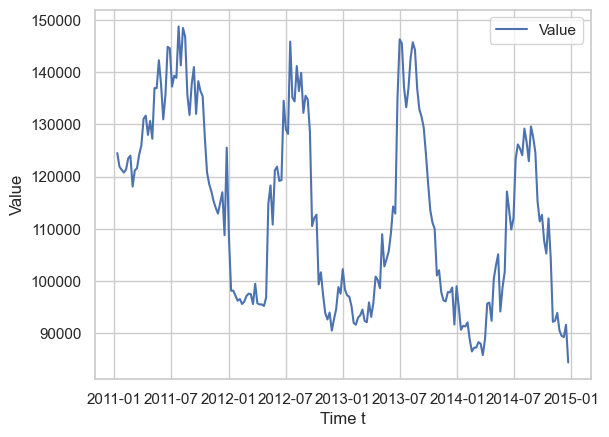

<Figure size 1000x700 with 0 Axes>

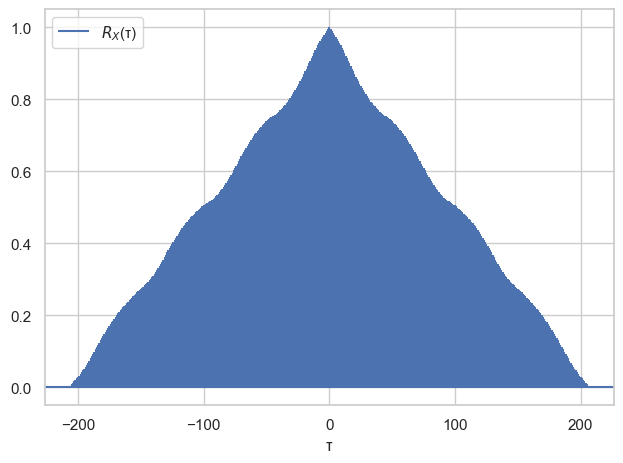

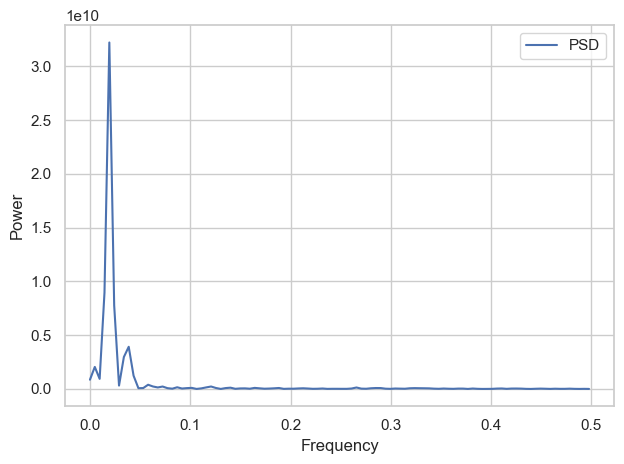

Max Power at period 51.75


In [3]:
ts_plots(weekly_overall, auto_lags = None) # Plot the timeseries, autocorrelation and PSD

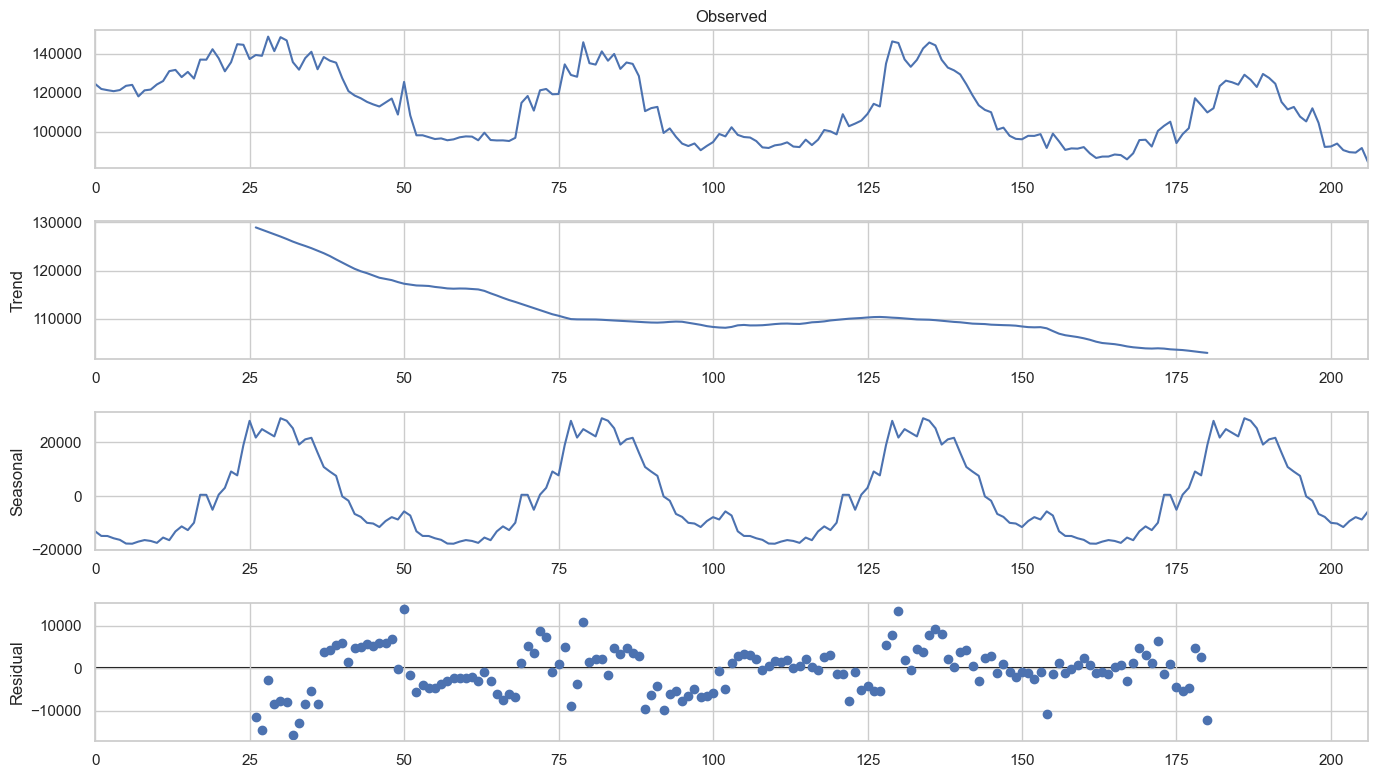

In [4]:
plt.rc('figure',figsize=(14,8))
plt.rc('font',size=14)
result = seasonal_decompose(weekly_overall.value.values, period = 52, model='additive') # seasonal decomposition of overall ts
fig = result.plot()
# Appears to have 1st order trend with seasonal component, period of 52

MAPE = 12.79%


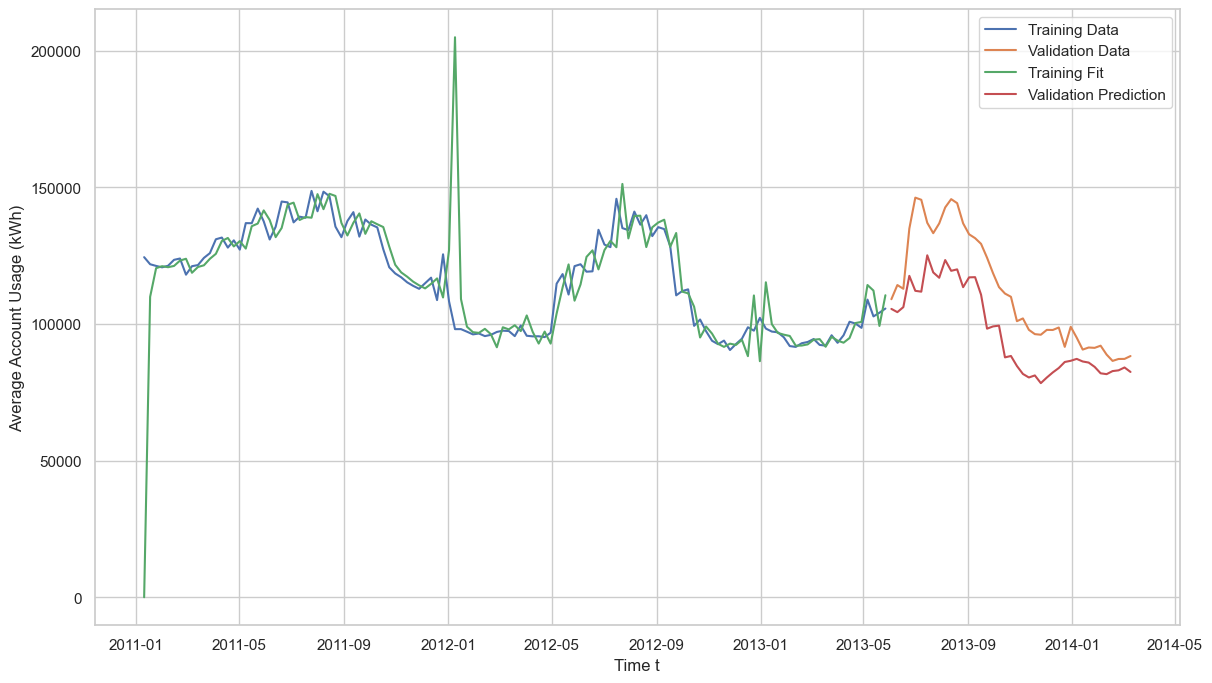

In [5]:
train, valid, fit, predictions = walk_forward_validation_sarimax( # try to fit one validation set with a chosen SARIMAX
    weekly_overall,
    round(len(weekly_overall)*0.2),
    round(len(weekly_overall)*0.2), 
    0, 1, 1, 0, 1, 1, 52,
    type = 'valid')

plt.plot(train, label = 'Training Data') # plot validation vs. fit
plt.plot(valid, label = 'Validation Data')
plt.plot(fit, label = 'Training Fit')
plt.plot(predictions, label = 'Validation Prediction')
plt.xlabel('Time t')
plt.ylabel('Average Account Usage (kWh)')
plt.legend()
print("MAPE = {:0.2%}".format(MAPE(valid.value.values, predictions.values)))

In [6]:
# Hyperparameter tuning on overall data
best_p, best_d, best_q = np.nan, np.nan, np.nan
best_mape = 1e9
for p in [0, 1, 2]:
    for d in [0, 1, 2]:
        for q in [0, 1, 2]:
            train, valid, fit, predictions = train, test_sets, fit, test_predictions = walk_forward_validation_sarimax( # try to fit one validation set with a vanilla SARIMAX
                weekly_overall,
                round(len(weekly_overall)*0.2),
                round(len(weekly_overall)*0.2), 
                p, d, q, p, d, q, 52,
                type = 'valid')
            current_mape =  MAPE(valid.value.values, predictions.values)
            print('p={}, d={}, q={}, MAPE={}'.format(p, d, q, current_mape))
            if current_mape < best_mape:
                best_mape = current_mape
                best_p, best_d, best_q = p, d, q
# Result: Optimal p=1, d=2, q=1 with MAPE = 10.4%

p=0, d=0, q=0, MAPE=1.0
p=0, d=0, q=1, MAPE=0.6383864520169075


KeyboardInterrupt: 

MAPE = 10.43%


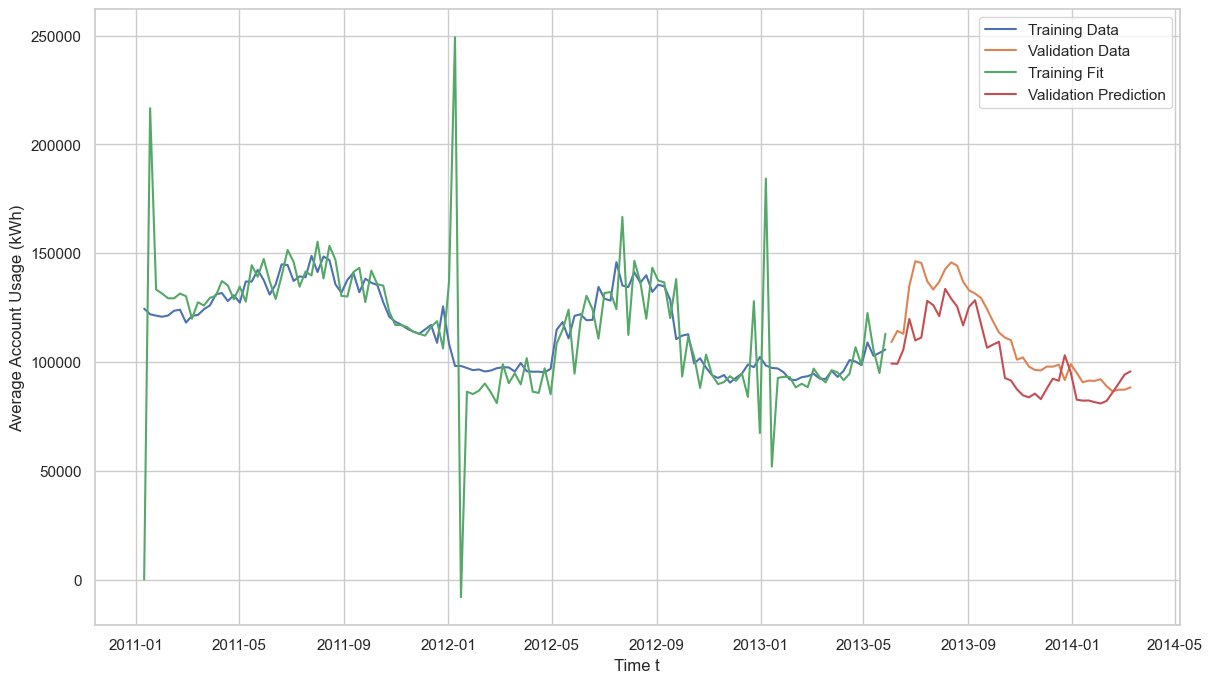

In [6]:
# Validation set on all data with best hyperparameters
best_p, best_d, best_q = 1, 2, 1
train, valid, fit, predictions = walk_forward_validation_sarimax( # try to fit one validation set with a vanilla SARIMAX
    weekly_overall,
    round(len(weekly_overall)*0.2),
    round(len(weekly_overall)*0.2), 
    best_p, best_d, best_q, best_p, best_d, best_q, 52,
    type = 'valid')

plt.plot(train, label = 'Training Data') # plot validation vs. fit
plt.plot(valid, label = 'Validation Data')
plt.plot(fit, label = 'Training Fit')
plt.plot(predictions, label = 'Validation Prediction')
plt.xlabel('Time t')
plt.ylabel('Average Account Usage (kWh)')
plt.legend()
print("MAPE = {:0.2%}".format(MAPE(valid.value.values, predictions.values)))

In [38]:
# SARIMA regression by account
account_numbers = [] # track the account number
account_train = [] # training set
account_fit = [] # fit set
account_test_1 = [] # test sets 1-3
account_test_2 = []
account_test_3 = []
account_prediction_1 = [] # prediction sets 1-3
account_prediction_2 = []
account_prediction_3 = []
account_mape_1 = [] # MAPE 1-3
account_mape_2 = []
account_mape_3 = []
account_errors = []
for account_number in tqdm(weekly_usage.account.unique()[0:3]):
    try:
        df_account = create_kwh_dataframe(weekly_usage[weekly_usage.account == account_number]).drop(columns = ['account'])
        train, tests, fit, predictions = walk_forward_validation_sarimax(
            df_account,
            round(len(df_account)*0.20),
            round(len(df_account)*0.20),
            best_p, best_d, best_q, best_p, best_d, best_q, 52,
            type = 'test')
        account_numbers.append(account_number)
        account_train.append(train) # one df
        account_fit.append(fit) # one df
        account_test_1.append(tests[0]) # one of three dfs
        account_test_2.append(tests[1])
        account_test_3.append(tests[2]) 
        account_prediction_1.append(predictions[0]) # one of three dfs
        account_prediction_2.append(predictions[1])
        account_prediction_3.append(predictions[2])
        account_mape_1.append(MAPE(tests[0].value.values, predictions[0].values)) # one of three dfs
        account_mape_2.append(MAPE(tests[1].value.values, predictions[1].values)) 
        account_mape_3.append(MAPE(tests[2].value.values, predictions[2].values)) 
    except:
        account_errors.append(account_number)
        continue
account_results = pd.DataFrame({ # Create DataFrame for results
    'account_numbers' : account_numbers,
    'account_train' : account_train,
    'account_fit' : account_fit,
    'account_test_1' : account_test_1,
    'account_test_2' : account_test_2,
    'account_test_3' : account_test_3,
    'account_prediction_1' : account_prediction_1,
    'account_prediction_2' : account_prediction_2,
    'account_prediction_3' : account_prediction_3,
    'account_mape_1' : account_mape_1,
    'account_mape_2' : account_mape_2,
    'account_mape_3' : account_mape_3
})
account_results.to_json('sarimax_account_results.json') # save to JSON

100%|██████████| 3/3 [02:28<00:00, 49.45s/it]


In [7]:
plt.hist(np.array(account_mape)*100, bins = np.arange(0, 200, 10))
plt.xticks(np.arange(0, 200, 10))
plt.xlabel('MAPE (%)')
plt.ylabel('Number of Accounts')

NameError: name 'account_mape' is not defined

In [ ]:
index = account_mape.index(min(account_mape))
plt.plot(account_train[index], label = 'Training Data')
plt.plot(account_valid[index], label = 'Validation Data')
plt.plot(account_test[index], label = 'Test Data')
plt.plot(account_fit[index], label = 'Training Fit')
plt.plot(account_valid_fit[index], label = 'Validation Fit')
plt.plot(account_prediction[index], label = 'Test Prediction')
plt.xlabel('Time t')
plt.ylabel('Average Account Usage (kWh)')
plt.legend()
print("MAPE = {:0.2%}".format(MAPE(test.value.values, prediction.values)))

NameError: name 'account_mape' is not defined

In [ ]:
# Total MAPE
mapes  = []
for i in np.arange(len(account_mape)):
    actual = account_test[i].value.values
    pred = account_prediction[i].values
    mapes = mapes + (np.abs((actual - pred))/(actual)).tolist()
print('Total MAPE is {:.1%}'.format(np.mean(mapes)))
print('Median MAPE is {:.1%}'.format(np.median(mapes)))

Total MAPE is 30.7%
Median MAPE is 15.9%


00:14:11 - cmdstanpy - INFO - Chain [1] start processing
00:14:11 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 18.92%


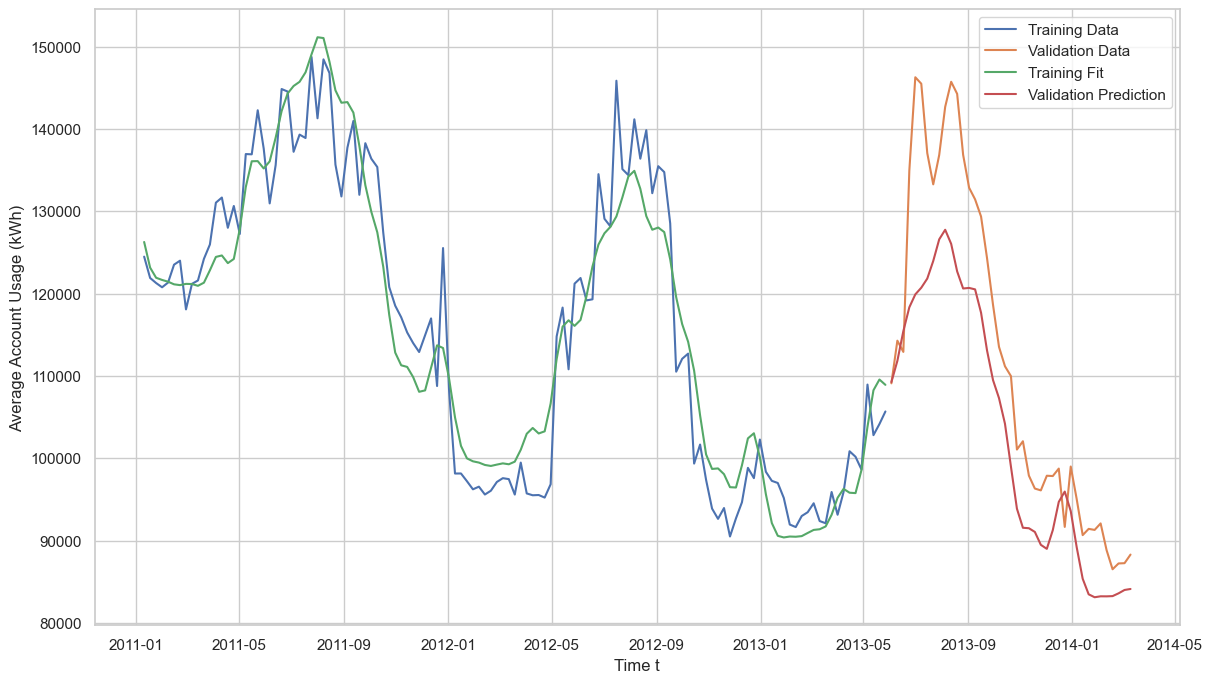

In [9]:
# Initial Validation set for FB Prophet Model
train, valid, fit, predictions = walk_forward_validation_prophet( # try to fit one validation set with a vanilla SARIMAX
    weekly_overall,
    round(len(weekly_overall)*0.2),
    round(len(weekly_overall)*0.2), 
    type = 'valid',
    period = 365.25,
    fourier_order = 12,
    monthly = False
    )

plt.plot(train, label = 'Training Data') # plot validation vs. fit
plt.plot(valid, label = 'Validation Data')
plt.plot(fit, label = 'Training Fit')
plt.plot(predictions, label = 'Validation Prediction')
plt.xlabel('Time t')
plt.ylabel('Average Account Usage (kWh)')
plt.legend()
print("MAPE = {:0.2%}".format(MAPE(valid.value.values, predictions.values)))

00:20:48 - cmdstanpy - INFO - Chain [1] start processing
00:20:48 - cmdstanpy - INFO - Chain [1] done processing
00:20:48 - cmdstanpy - INFO - Chain [1] start processing
00:20:48 - cmdstanpy - INFO - Chain [1] done processing
00:20:48 - cmdstanpy - INFO - Chain [1] start processing
00:20:48 - cmdstanpy - INFO - Chain [1] done processing
00:20:48 - cmdstanpy - INFO - Chain [1] start processing
00:20:48 - cmdstanpy - INFO - Chain [1] done processing
00:20:48 - cmdstanpy - INFO - Chain [1] start processing
00:20:48 - cmdstanpy - INFO - Chain [1] done processing
00:20:49 - cmdstanpy - INFO - Chain [1] start processing
00:20:49 - cmdstanpy - INFO - Chain [1] done processing
00:20:49 - cmdstanpy - INFO - Chain [1] start processing
00:20:49 - cmdstanpy - INFO - Chain [1] done processing
00:20:49 - cmdstanpy - INFO - Chain [1] start processing
00:20:49 - cmdstanpy - INFO - Chain [1] done processing
00:20:49 - cmdstanpy - INFO - Chain [1] start processing
00:20:49 - cmdstanpy - INFO - Chain [1]

MAPE = 22.43%


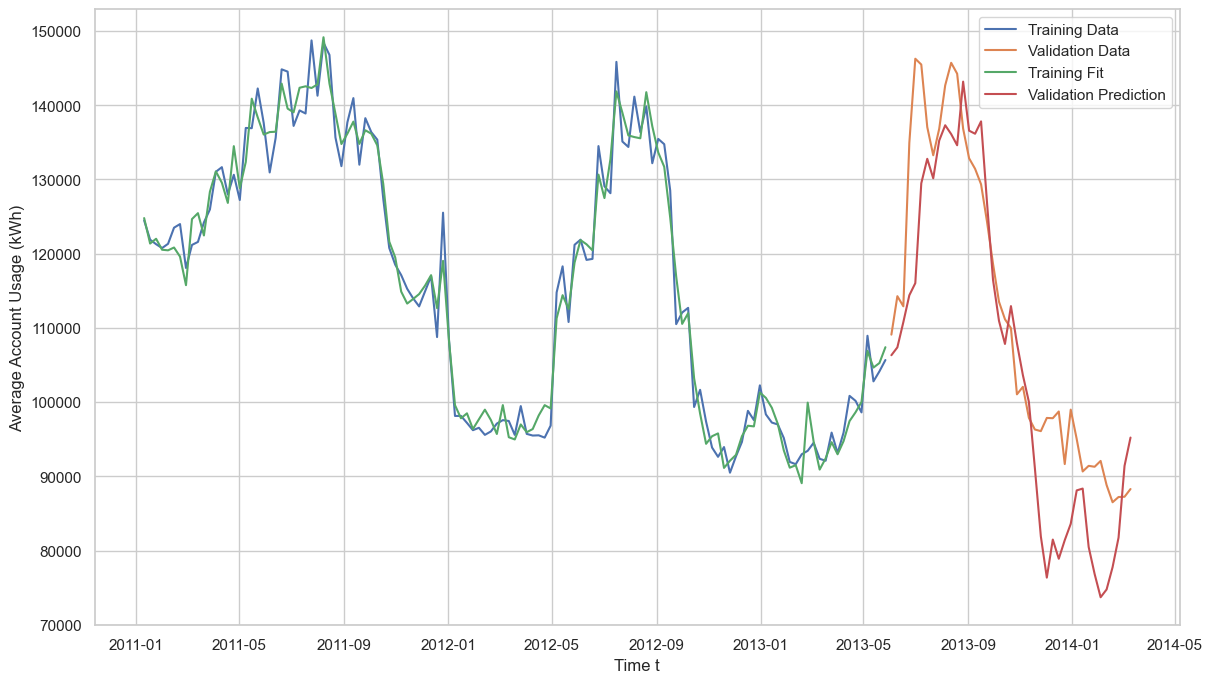

In [13]:
# Validation set on all data with best hyperparameters
best_period = np.nan
best_monthly = np.nan
best_fourier_order = np.nan
best_mape = 1e9
for period in [364, 365, 365.25, 366]:
    for monthly in [True, False]:
        for fourier_order in np.arange(6, 20, 2):
            train, valid, fit, predictions = walk_forward_validation_prophet(
                weekly_overall,
                round(len(weekly_overall)*0.2),
                round(len(weekly_overall)*0.2), 
                type = 'valid',
                period = 365.25,
                fourier_order = 12,
                monthly = False
                )
            mape = MAPE(valid.value.values, predictions.values)
            if mape<best_mape:
                best_mape = mape
                best_period = period
                best_fourier_order = fourier_order
                best_monthly = monthly
best_period, best_fourier_order, best_monthly, best_mape

# Initial Validation set for FB Prophet Model
train, valid, fit, predictions = walk_forward_validation_prophet( # try to fit one validation set with a vanilla SARIMAX
    weekly_overall,
    round(len(weekly_overall)*0.2),
    round(len(weekly_overall)*0.2), 
    type = 'valid',
    period = best_period,
    fourier_order = best_fourier_order,
    monthly = best_monthly
    )

plt.plot(train, label = 'Training Data') # plot validation vs. fit
plt.plot(valid, label = 'Validation Data')
plt.plot(fit, label = 'Training Fit')
plt.plot(predictions, label = 'Validation Prediction')
plt.xlabel('Time t')
plt.ylabel('Average Account Usage (kWh)')
plt.legend()
print("MAPE = {:0.2%}".format(MAPE(valid.value.values, predictions.values)))

In [ ]:
print("MAPE for the first region = {:0.2%}".format(MAPE(test.value.values[:int(len(test.value.values)/3)],prediction.values[:int(len(prediction.values)/3)])))
print("MAPE for the secont region = {:0.2%}".format(MAPE(test.value.values[int(len(test.value.values)/3):int(2*len(test.value.values)/3)],prediction.values[int(len(prediction.values)/3):int(2*len(test.value.values)/3)])))
print("MAPE for the third region = {:0.2%}".format(MAPE(test.value.values[int(2*len(test.value.values)/3):],prediction.values[int(2*len(prediction.values)/3):])))

MAPE for the first region = 4.60%
MAPE for the secont region = 6.72%
MAPE for the third region = 13.10%


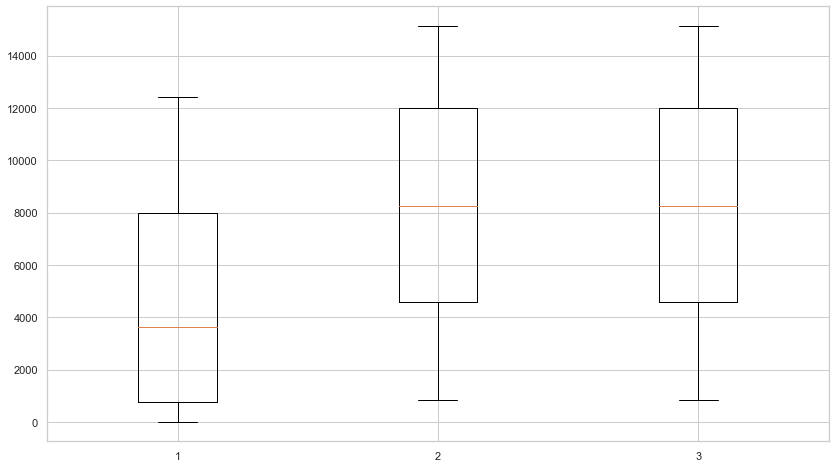

In [ ]:
test_first_third = test.value.values[:int(len(test.value.values)/3)]
prediction_first_third = prediction.values[:int(len(prediction.values)/3)]
error_first_third = np.abs(test_first_third-prediction_first_third)

test_second_third = test.value.values[int(len(test.value.values)/3):int(2*len(test.value.values)/3)]
prediction_second_third = prediction.values[int(len(test.value.values)/3):int(2*len(test.value.values)/3)]
error_second_third = np.abs(test_second_third-prediction_second_third)

test_third_third = test.value.values[int(2*len(test.value.values)/3):]
prediction_third_third = prediction.values[int(2*len(prediction.values)/3):]
error_third_third = np.abs(test_third_third-prediction_third_third)


data = [error_first_third,error_second_third,error_second_third]
plt.boxplot(data)
plt.ylabel("Absolute Error")
plt.xlabel("Region")

MAPE = 14.85%


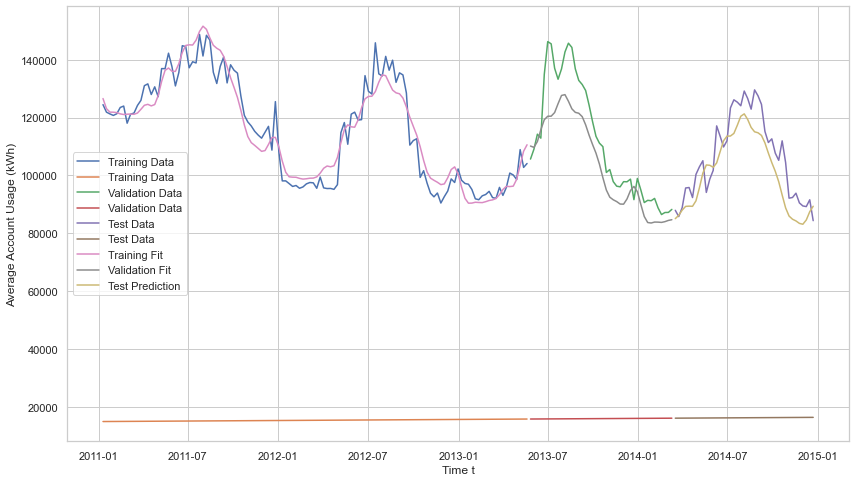

In [128]:
plt.plot(train, label = 'Training Data')
plt.plot(valid, label = 'Validation Data')
plt.plot(test, label = 'Test Data')
plt.plot(fit, label = 'Training Fit')
plt.plot(valid_fit, label = 'Validation Fit')
plt.plot(prediction, label = 'Test Prediction')
plt.xlabel('Time t')
plt.ylabel('Average Account Usage (kWh)')
plt.legend()
print("MAPE = {:0.2%}".format(MAPE([item[0] for item in test.values], prediction.values)))

In [129]:
a = [item[0] for item in test.values]
print("MAPE for the first region = {:0.2%}".format(MAPE(a[:int(len(a)/3)],prediction.values[:int(len(prediction.values)/3)])))
print("MAPE for the secont region = {:0.2%}".format(MAPE(a[int(len(a)/3):int(2*len(a)/3)],prediction.values[int(len(prediction.values)/3):int(2*len(prediction.values)/3)])))
print("MAPE for the third region = {:0.2%}".format(MAPE(a[int(2*len(a)/3):],prediction.values[int(2*len(prediction.values)/3):])))

MAPE for the first region = 8.92%
MAPE for the secont region = 7.05%
MAPE for the third region = 11.43%


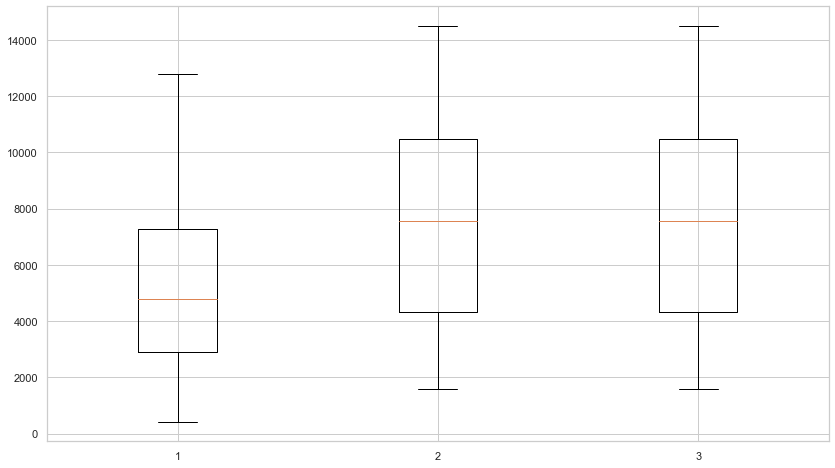

In [137]:
prediction = [item for item in prediction['yhat']]

test_first_third = a[:int(len(a)/3)]
prediction_first_third = prediction[:int(len(prediction)/3)]
error_first_third = np.abs(np.array(test_first_third)-np.array(prediction_first_third))

test_second_third = a[int(len(a)/3):int(2*len(a)/3)]
prediction_second_third = prediction[int(len(prediction)/3):int(2*len(prediction)/3)]
error_second_third = np.abs(np.array(test_second_third)-np.array(prediction_second_third))

test_third_third = a[int(2*len(a)/3):]
prediction_third_third = prediction[int(2*len(prediction)/3):]
error_third_third = np.abs(np.array(test_third_third)-np.array(prediction_third_third))


data = [error_first_third,error_second_third,error_second_third]
plt.boxplot(data);


In [154]:
from statsmodels.tsa.arima.model import ARIMA

def walk_forward_validation_arima(df, n_test, n_validation, p, d, q):
    """
    Perform walk-forward validation with a defined n_test in the data

    Parameters
    ----------
    df (pd.DataFrame) - input timeseries DataFrame
    n_test (int) - number of test points
    p, d, q, s_p, s_d, s_q, seasonality (int) - SARIMAX parameters
    """
    train, valid, test = train_valid_test_split(df, n_test, n_validation)
    model = ARIMA(
        train,
        order = (p, d, q)
    )
    model_fit = model.fit()
 
    # walk forward
    predictions1 = model_fit.forecast(len(test)*2)
    predictions = predictions1[int(len(predictions1)/2):]
    valid_fit = predictions1[:int(len(predictions1)/2)]
    # estimate error
    return train, valid, test, model_fit.predict(), valid_fit, predictions



In [155]:
train, valid, test, fit, valid_fit, prediction = walk_forward_validation_arima(weekly_overall, round(len(weekly_overall)*0.80), round(len(weekly_overall)*0.6), 0, 1, 1)

MAPE = 11.53%


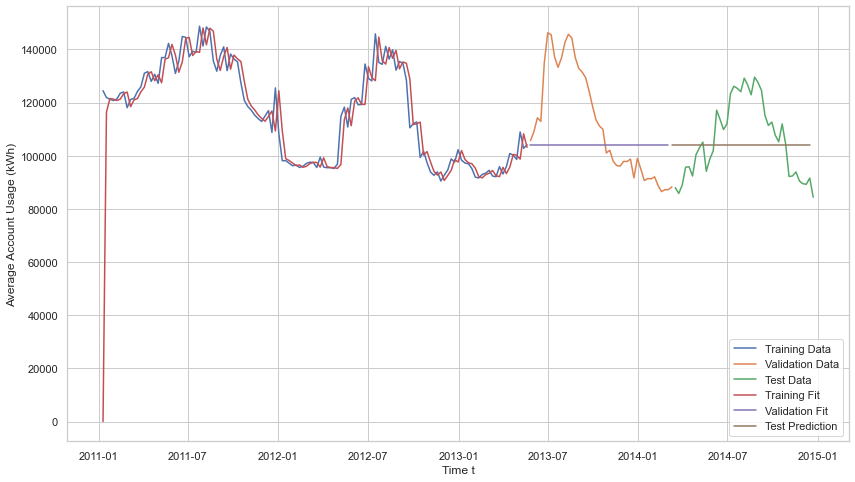

In [156]:
plt.plot(train, label = 'Training Data')
plt.plot(valid, label = 'Validation Data')
plt.plot(test, label = 'Test Data')
plt.plot(fit, label = 'Training Fit')
plt.plot(valid_fit, label = 'Validation Fit')
plt.plot(prediction, label = 'Test Prediction')
plt.xlabel('Time t')
plt.ylabel('Average Account Usage (kWh)')
plt.legend()
print("MAPE = {:0.2%}".format(MAPE(test.value.values, prediction.values)))

In [157]:
print("MAPE for the first region = {:0.2%}".format(MAPE(test.value.values[:int(len(test.value.values)/3)],prediction.values[:int(len(prediction.values)/3)])))
print("MAPE for the secont region = {:0.2%}".format(MAPE(test.value.values[int(len(test.value.values)/3):int(2*len(test.value.values)/3)],prediction.values[int(len(prediction.values)/3):int(2*len(test.value.values)/3)])))
print("MAPE for the third region = {:0.2%}".format(MAPE(test.value.values[int(2*len(test.value.values)/3):],prediction.values[int(2*len(prediction.values)/3):])))

MAPE for the first region = 9.37%
MAPE for the secont region = 14.55%
MAPE for the third region = 10.53%


Text(0.5, 0, 'Region')

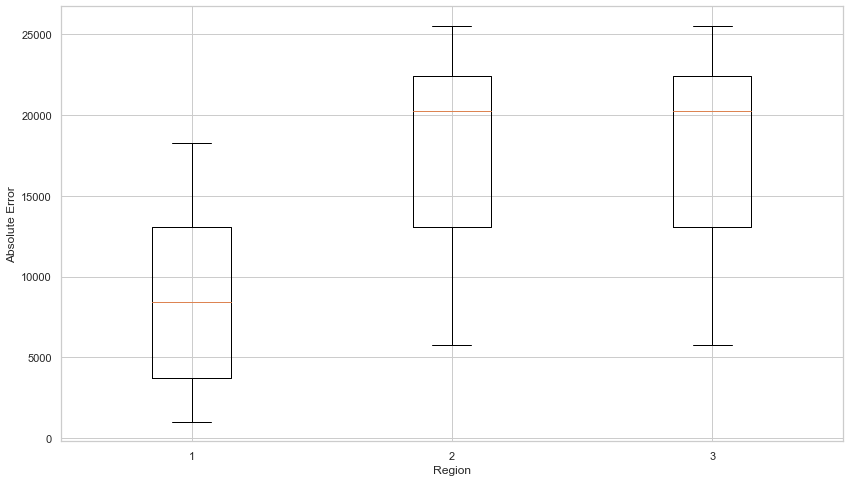

In [158]:
test_first_third = test.value.values[:int(len(test.value.values)/3)]
prediction_first_third = prediction.values[:int(len(prediction.values)/3)]
error_first_third = np.abs(test_first_third-prediction_first_third)

test_second_third = test.value.values[int(len(test.value.values)/3):int(2*len(test.value.values)/3)]
prediction_second_third = prediction.values[int(len(test.value.values)/3):int(2*len(test.value.values)/3)]
error_second_third = np.abs(test_second_third-prediction_second_third)

test_third_third = test.value.values[int(2*len(test.value.values)/3):]
prediction_third_third = prediction.values[int(2*len(prediction.values)/3):]
error_third_third = np.abs(test_third_third-prediction_third_third)


data = [error_first_third,error_second_third,error_second_third]
plt.boxplot(data)
plt.ylabel("Absolute Error")
plt.xlabel("Region")